<a href="https://colab.research.google.com/github/YZCUS/py-SpermTracking/blob/main/071422_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries import and Drive connection**

In [30]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

# import numerical libraries
import pandas as pd
import numpy as np
import math
import statistics

#import graphical libraries
import matplotlib.pyplot as plt
import seaborn as sns

# import sampling, modeling algorithms and dimensionity reduciton
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Functions for features extraction**

In [3]:
def included_angle(d1,d2):
    angle1=math.atan2(d1[1],d1[0])
    angle2=math.atan2(d2[1],d2[0])
    if angle1<0:
      angle1+=2*math.pi
    if angle2<0:
      angle2+=2*math.pi
    included_angle=angle2-angle1
    return included_angle

def SDofDV(df):
  df[['dx','dy','dz']]=df[['Position X','Position Y','Position Z']].diff()
  for i in range(1,len(df)):
    df.loc[i,'dv_xy']=included_angle(df.loc[i-1,['dx','dy']],df.loc[i,['dx','dy']])
    df.loc[i,'dv_yz']=included_angle(df.loc[i-1,['dy','dz']],df.loc[i,['dy','dz']])
    df.loc[i,'dv_zx']=included_angle(df.loc[i-1,['dz','dx']],df.loc[i,['dz','dx']])
  return (df['dv_xy'].std()+df['dv_yz'].std()+df['dv_zx'].std())/3

def VCL(df):
  df[['dx','dy','dz']]=df[['Position X','Position Y','Position Z']].diff()
  df['vcl']=(df['dx']**2+df['dy']**2+df['dz']**2)**0.5/0.9
  return df['vcl'].mean()

def VSL(df):
  df[['mdx','mdy','mdz']]=df[['Position X','Position Y','Position Z']].diff(periods=len(df)-1)
  VSL=(df.loc[len(df)-1,'mdx']**2+df.loc[len(df)-1,'mdy']**2+df.loc[len(df)-1,'mdz']**2)**0.5/0.9/(len(df)-1)
  return VSL

def VAP(df):
  df[['apx','apy','apz']]=df[['Position X','Position Y','Position Z']].rolling(3,center=True).mean()
  df.loc[0,['apx','apy','apz']]=np.array(df.loc[0,['Position X','Position Y','Position Z']])
  df.loc[len(df)-1,['apx','apy','apz']]=np.array(df.loc[len(df)-1,['Position X','Position Y','Position Z']])
  df[['adx','ady','adz']]=df[['apx','apy','apz']].diff()
  df['vap']=(df['adx']**2+df['ady']**2+df['adz']**2)**0.5/0.9
  return df['vap'].mean()

# **Read the csv files, Convert into measurements, Collect as DataFrames**

Length Filter (Optional)

In [4]:
# the trajectories shorter than this values will be filtered out and won't be included in building classification model
lenfilter=0

In [5]:
# input the trajectories numbers of each groups after pre-processing from imaris file
nVisTJnbList=[145,159,28] #[M2,HTF,SW]
nVisdata=[[],[],[]] #[M2,HTF,SW]
for i,j in enumerate(nVisTJnbList):
  if i==0:
    for k in range(j):
      path='/content/drive/MyDrive/071422_sperm_mod/M2_sperm_mod/M2_sperm_non_vis_{}.csv'.format(k+1)
      df=pd.read_csv(path)
      if len(df)>lenfilter: nVisdata[i].append([SDofDV(df),VCL(df),VSL(df),VAP(df),VSL(df)/VCL(df)*100,VSL(df)/VAP(df)*100,VAP(df)/VCL(df)*100,len(df)])
  elif i==1:
    for k in range(j):
      path='/content/drive/MyDrive/071422_sperm_mod/HTF_sperm_mod/HTF_sperm_non_vis_{}.csv'.format(k+1)
      df=pd.read_csv(path)
      if len(df)>lenfilter: nVisdata[i].append([SDofDV(df),VCL(df),VSL(df),VAP(df),VSL(df)/VCL(df)*100,VSL(df)/VAP(df)*100,VAP(df)/VCL(df)*100,len(df)])
  else:
    for k in range(j):
      path='/content/drive/MyDrive/032822_viscosity_statistic/040722_viscosity_statistic/040722_SW_sperm/SW_sperm_invivo_vis_{}.csv'.format(k+1)
      df=pd.read_csv(path)
      if len(df)>lenfilter: nVisdata[i].append([SDofDV(df),VCL(df),VSL(df),VAP(df),VSL(df)/VCL(df)*100,VSL(df)/VAP(df)*100,VAP(df)/VCL(df)*100,len(df)])

In [6]:
df_M2_non_vis=pd.DataFrame(np.array(nVisdata[0]),columns=['SDofDV','VCL','VSL','VAP','LIN','STR','WOB','Len'])
df_HTF_non_vis=pd.DataFrame(np.array(nVisdata[1]),columns=['SDofDV','VCL','VSL','VAP','LIN','STR','WOB','Len'])
df_invivo_vis=pd.DataFrame(np.array(nVisdata[2]),columns=['SDofDV','VCL','VSL','VAP','LIN','STR','WOB','Len'])

In [7]:
Visdata=[[],[],[],[]]
for i,j in enumerate([38,43,36,37]): #[0p0,0p2,0p4,0p6] Set 1
  for k in range(j):
    path='/content/drive/MyDrive/071422_sperm_mod/080122_sperm_vis/HTF_sperm_vis/HTF_sperm_0p{}_{}.csv'.format(i*2,k+1)
    df=pd.read_csv(path)
    if len(df)>lenfilter: Visdata[i].append([SDofDV(df),VCL(df),VSL(df),VAP(df),VSL(df)/VCL(df)*100,VSL(df)/VAP(df)*100,VAP(df)/VCL(df)*100,len(df)])
for i,j in enumerate([42,42,35,41]): #[0p0,0p2,0p4,0p6] Set 2
  for k in range(j):
    path='/content/drive/MyDrive/071422_sperm_mod/081222_sperm_vis/HTF_sperm_vis/HTF_sperm_0p{}_{}.csv'.format(i*2,k+1)
    df=pd.read_csv(path)
    if len(df)>lenfilter: Visdata[i].append([SDofDV(df),VCL(df),VSL(df),VAP(df),VSL(df)/VCL(df)*100,VSL(df)/VAP(df)*100,VAP(df)/VCL(df)*100,len(df)])
for i,j in enumerate([37,38,50,40]): #[0p0,0p2,0p4,0p6] Set 3
  for k in range(j):
    path='/content/drive/MyDrive/071422_sperm_mod/081422_sperm_vis/HTF_sperm_vis/HTF_sperm_0p{}_{}.csv'.format(i*2,k+1)
    df=pd.read_csv(path)
    if len(df)>lenfilter: Visdata[i].append([SDofDV(df),VCL(df),VSL(df),VAP(df),VSL(df)/VCL(df)*100,VSL(df)/VAP(df)*100,VAP(df)/VCL(df)*100,len(df)])

In [8]:
df_HTF_0p0=pd.DataFrame(np.array(Visdata[0]),columns=['SDofDV','VCL','VSL','VAP','LIN','STR','WOB','Len'])
df_HTF_0p2=pd.DataFrame(np.array(Visdata[1]),columns=['SDofDV','VCL','VSL','VAP','LIN','STR','WOB','Len'])
df_HTF_0p4=pd.DataFrame(np.array(Visdata[2]),columns=['SDofDV','VCL','VSL','VAP','LIN','STR','WOB','Len'])
df_HTF_0p6=pd.DataFrame(np.array(Visdata[3]),columns=['SDofDV','VCL','VSL','VAP','LIN','STR','WOB','Len'])

# **Data Normalization**

Record the segmentation of each groups

In [9]:
seg=[len(df_M2_non_vis),len(df_HTF_non_vis),len(df_invivo_vis),len(df_HTF_0p0),len(df_HTF_0p2),len(df_HTF_0p4),len(df_HTF_0p6)]

In [10]:
for i in range(1,len(seg)):
  seg[i]+=seg[i-1]

In [11]:
seg

[145, 304, 332, 449, 572, 693, 811]

Concat all data into one dataframe for dimensionality reduction by PCA

In [12]:
df_all=pd.concat([df_M2_non_vis,df_HTF_non_vis,df_invivo_vis,df_HTF_0p0,df_HTF_0p2,df_HTF_0p4,df_HTF_0p6])
df_all.to_csv('/content/drive/MyDrive/071422_sperm_mod/dataframes_all_bef_pca.csv')

In [13]:
parameters=[['SDofDV','VCL','VSL','VAP','LIN','STR','WOB'],['SDofDV','LIN','STR','WOB']]
mode=1

In [14]:
# Normalize SDofDV as the form of percentage (divide by 2pi)
df_all['SDofDV']=df_all['SDofDV']/math.pi*100/2

In [15]:
df_all

,SDofDV,VCL,VSL,VAP,LIN,STR,WOB,Len
0,7.315353,183.881343,167.271291,179.034866,90.966972,93.429450,97.364346,6.0
1,5.994550,142.856799,141.459066,141.618555,99.021585,99.887381,99.133227,5.0
2,2.217264,149.618903,149.108813,149.163957,99.659074,99.963031,99.695931,6.0
3,3.379577,138.817714,138.235610,138.361588,99.580671,99.908950,99.671421,5.0
4,7.094773,114.613390,107.110981,111.360371,93.454160,96.184109,97.161746,6.0
...,...,...,...,...,...,...,...,...
113,5.588573,42.077935,40.628139,41.182884,96.554499,98.652971,97.872875,7.0
114,30.256327,33.804574,29.033156,29.652397,85.885289,97.911665,87.717117,13.0
115,11.549236,50.204172,46.202394,46.637062,92.028994,99.067978,92.894794,14.0
116,20.563619,51.681002,46.048615,47.932172,89.101629,96.070370,92.746212,7.0


In [16]:
# Convert values into the range of [0,1]
mm=MinMaxScaler()
Allmtrx=np.array(df_all.loc[:,parameters[mode]])
mm_All=mm.fit_transform(Allmtrx)

# **Principal Component Analysis**

In [17]:
pca = PCA(n_components=len(parameters[mode]))
principalComponents = pca.fit_transform(mm_All)
pca.explained_variance_ratio_

array([0.78847488, 0.15528562, 0.05515524, 0.00108427])

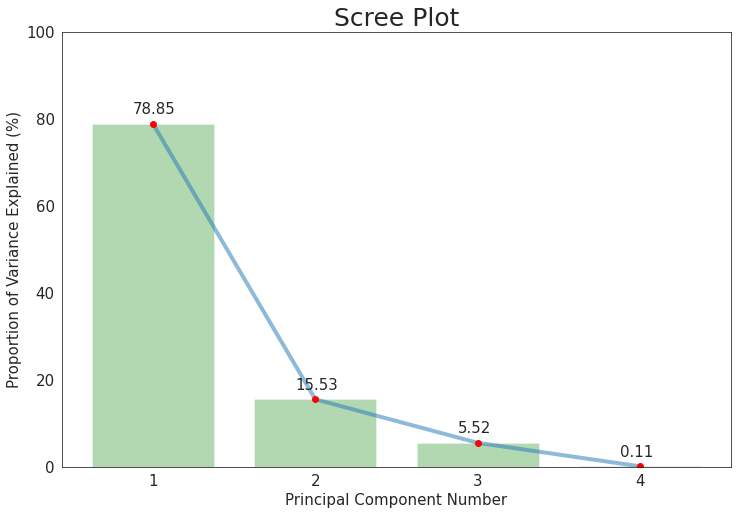

In [18]:
# Scree Plot for evulation of informaiton loss during PCA to determine dimensionality
importance = 100*pca.explained_variance_ratio_
sns.set_style('white')
plt.figure(figsize = (12,8))
plt.scatter(range(1,len(parameters[mode])+1),importance,c='r',s=35,zorder=2)
plt.plot(range(1,len(parameters[mode])+1),importance,linewidth=4,zorder=1,alpha=0.5)
plt.bar(range(1,len(parameters[mode])+1),importance,color='g',alpha=0.3,width=0.75)
for i in range(1,len(parameters[mode])+1):
    plt.annotate(round(importance[i-1],2),(i,importance[i-1]),textcoords="offset points",xytext=(-20,10),size=15)
plt.title('Scree Plot',fontsize=25)
plt.xlabel('Principal Component Number',fontsize=15)
plt.xticks(range(1,len(parameters[mode])+1),fontsize=15)
plt.ylabel('Proportion of Variance Explained (%)',fontsize=15)
plt.yticks([0,20,40,60,80,100],fontsize=15)
plt.savefig('/content/drive/MyDrive/071422_sperm_mod/PCA_Scree')
plt.show()

In [19]:
# Factor analysis
pca = PCA(n_components=2)
PrincipalComponents_all=pca.fit_transform(mm_All)
principalDF_all=pd.DataFrame(data=PrincipalComponents_all,columns=['principal component 1','principal component 2'])
pca.components_

array([[ 0.52837305, -0.55411561, -0.43439353, -0.47442605],
       [ 0.82541411,  0.36143504,  0.41839128,  0.1140395 ]])

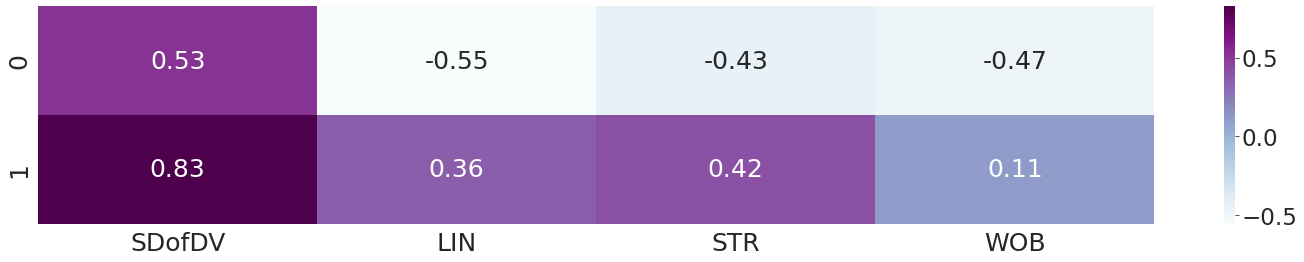

In [20]:
# Print out the projection matrix and visualize the parameters by heatmap
df_cm = pd.DataFrame(pca.components_, columns=parameters[mode])
plt.figure(figsize = (25,4))
ax = sns.heatmap(df_cm, annot=True, cmap="BuPu",annot_kws={"fontsize":25})
ax.yaxis.set_tick_params(labelsize=25)
ax.xaxis.set_tick_params(labelsize=25)
ax.figure.axes[-1].yaxis.set_tick_params(labelsize=23)
# plt.title('Factors Analysis', fontsize=30)
plt.savefig('/content/drive/MyDrive/071422_sperm_mod/PCA_Mtrx')
plt.show()

Divide the PCA result based on each dataset

In [21]:
mm_pca_M2_non=np.array(principalDF_all[:seg[0]])  #0
mm_pca_HTF_non=np.array(principalDF_all[seg[0]:seg[1]]) #1
mm_pca_invivo=np.array(principalDF_all[seg[1]:seg[2]]) #2
mm_pca_HTF_0p0=np.array(principalDF_all[seg[2]:seg[3]]) #3
mm_pca_HTF_0p2=np.array(principalDF_all[seg[3]:seg[4]]) #4
mm_pca_HTF_0p4=np.array(principalDF_all[seg[4]:seg[5]]) #5
mm_pca_HTF_0p6=np.array(principalDF_all[seg[5]:seg[6]]) #6

In [22]:
plotList=[
    [mm_pca_M2_non,0,seg[0]],
    [mm_pca_HTF_non,seg[0],seg[1]],
    [mm_pca_invivo,seg[1],seg[2],'Vivo'],
    [mm_pca_HTF_0p0,seg[2],seg[3],'1.0 mPa．s'],
    [mm_pca_HTF_0p2,seg[3],seg[4],'3.5 mPa．s'],
    [mm_pca_HTF_0p4,seg[4],seg[5],'10.5 mPa．s'],
    [mm_pca_HTF_0p6,seg[5],seg[6],'29.4 mPa．s']
]

In [23]:
# Combine the PCA result with original data
df_all=pd.DataFrame(df_all).reset_index(drop=True)
principalDF_all=pd.concat([principalDF_all,df_all],axis=1)

# **K-Mean clustering**

# **Bootstraping**

In [171]:
# Configure the Bootstrap
n_iterations = 10000
n_size = int(len(mm_pca_HTF_non)*0.75)
data=mm_pca_HTF_non

In [172]:
# Run Bootstrap
stats= list()
for i in range(n_iterations):
  # prepare train set and test set
  train = resample(data,n_samples=n_size)
  test = np.array([x for x in data if x.tolist() not in train.tolist()])
  # fit model
  kmeans = KMeans(n_clusters=2,random_state=0).fit(train)
  center_sort = kmeans.cluster_centers_[kmeans.cluster_centers_[:,0].argsort()]
  temp=[center_sort[0],center_sort[1]]
  label_sort = np.sort(kmeans.labels_)
  mid = label_sort[len(label_sort)//2]
  temp.append(round((sum(kmeans.labels_)/len(kmeans.labels_)*100),2)) if mid==0 else temp.append(round((100-sum(kmeans.labels_)/len(kmeans.labels_)*100),2))
  # evaluate model
  predictions = kmeans.predict(test)
  temp.append(round((sum(predictions)/len(predictions)*100),2)) if mid==0 else temp.append(round((100-sum(predictions)/len(predictions)*100),2))
  stats.append(temp)

In [173]:
df_bs=pd.DataFrame(np.array(stats),columns=['LC','RC','Label (%)','Pred (%)'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [174]:
df_bs

,LC,RC,Label (%),Pred (%)
0,"[-0.16238043526893947, 0.001460963671311549]","[0.6205422862442259, -0.052918793889596964]",21.85,38.96
1,"[-0.11817084431206365, 0.00332072059476563]","[0.5960755879189658, -0.008350164263163547]",31.09,23.88
2,"[-0.1750272941042269, -0.0023052709046401665]","[0.4586994663447268, 0.028425867203687727]",35.29,39.71
3,"[-0.19149718965347085, -0.02851233930842369]","[0.4955859000654505, -0.010599066373692222]",36.97,34.21
4,"[-0.1670494008178181, -0.005729260518744322]","[0.5575665099130585, -0.047990022000260896]",32.77,34.29
...,...,...,...,...
9995,"[-0.18488473907938713, -0.0039419969245436184]","[0.4788048189126149, -0.02756161598821614]",35.29,42.11
9996,"[-0.15547006358905363, 0.004555688957863043]","[0.5384817779439258, -0.017174727817535623]",40.34,30.67
9997,"[-0.12690369852503083, 0.016354780258921692]","[0.5541630355257205, -0.028077791818214178]",31.09,36.11
9998,"[-0.16461124190838233, 0.008011802866260152]","[0.5389218282998902, -0.06022459687936242]",38.66,29.33


In [175]:
df_bs.loc[:,'LC'].mean(),df_bs.loc[:,'RC'].mean()

(array([-0.14890637,  0.00958351]), array([ 0.54140679, -0.02655105]))

In [176]:
df_bs.loc[:,'Label (%)'].mean(),df_bs.loc[:,'Label (%)'].std(),df_bs.loc[:,'Pred (%)'].mean(),df_bs.loc[:,'Pred (%)'].std()

(32.99241199999978, 5.8835751535877225, 32.624174999999944, 6.0938721932122695)

In [177]:
df_bs.loc[:,'Label (%)'].max(),df_bs.loc[:,'Label (%)'].min(),df_bs.loc[:,'Pred (%)'].max(),df_bs.loc[:,'Pred (%)'].min()

(49.58, 12.61, 76.47, 12.12)

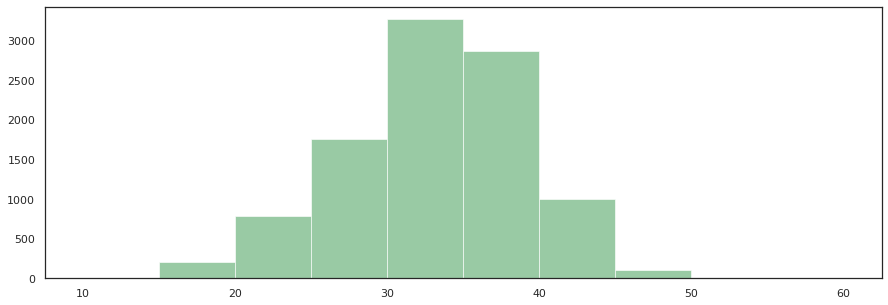

In [178]:
sns.set_style('white')
fig=plt.figure(figsize=(15,5))
plt.hist(df_bs['Label (%)'],range=[10,60],color='g',alpha=0.6)
plt.show()

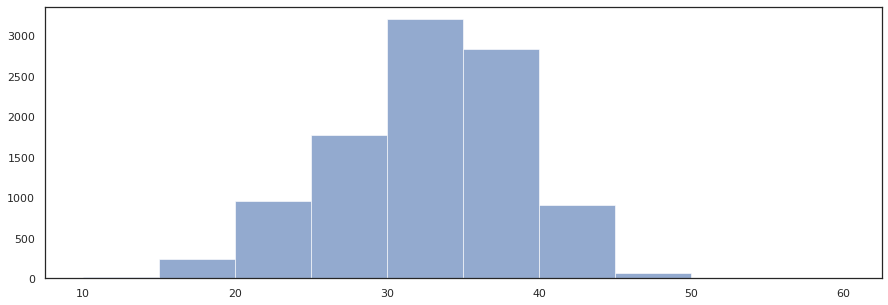

In [179]:
sns.set_style('white')
fig=plt.figure(figsize=(15,5))
plt.hist(df_bs['Pred (%)'],range=[10,60],color='b',alpha=0.6)
plt.show()

# Model built by non-viscosity data from three mice

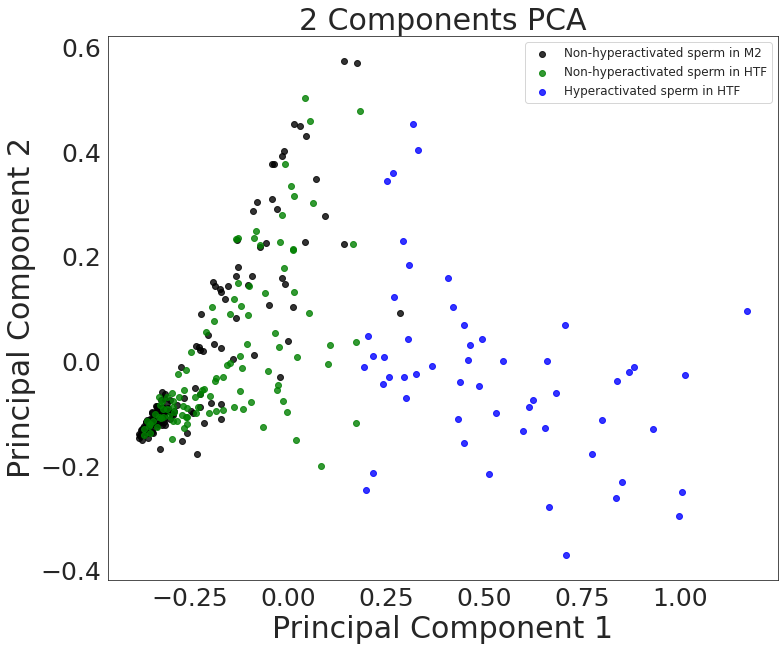

In [35]:
hyidx=[]
nhyidx=[]
sns.set_style('white')
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(1,1,1)
ax.set_title('2 Components PCA', fontsize = 30)
kmeans = KMeans(n_clusters=2,random_state=0).fit(mm_pca_HTF_non)
kdot=ax.scatter(principalDF_all.loc[:seg[0],'principal component 1'],principalDF_all.loc[:seg[0],'principal component 2'],c='k',alpha=0.8)
for i,j in enumerate(kmeans.labels_):
    if j==0:
        bdot=ax.scatter(principalDF_all.loc[seg[0]+i,'principal component 1'],principalDF_all.loc[seg[0]+i,'principal component 2'],c='b',alpha=0.8)
        hyidx.append(seg[0]+i)
    else:
        gdot=ax.scatter(principalDF_all.loc[seg[0]+i,'principal component 1'],principalDF_all.loc[seg[0]+i,'principal component 2'],c='g',alpha=0.8)
        nhyidx.append(seg[0]+i)
ax.set_xlabel('Principal Component 1', fontsize = 30)
ax.set_ylabel('Principal Component 2', fontsize = 30)
ax.yaxis.set_tick_params(labelsize=25)
ax.xaxis.set_tick_params(labelsize=25)
ax.legend([kdot,gdot,bdot],['Non-hyperactivated sperm in M2','Non-hyperactivated sperm in HTF','Hyperactivated sperm in HTF'],fontsize=12)
plt.savefig('/content/drive/MyDrive/071422_sperm_mod/PCA_Kmean_mod')
plt.show()

In [36]:
len(hyidx),len(nhyidx),len(hyidx)/len(mm_pca_HTF_non)*100

(54, 105, 33.9622641509434)

# Viscosity data fit the model

In [37]:
kmeans.predict(mm_pca_HTF_0p0),100-sum(kmeans.predict(mm_pca_HTF_0p0))/len(kmeans.predict(mm_pca_HTF_0p0))*100

(array([0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1], dtype=int32), 23.076923076923066)

In [38]:
kmeans.predict(mm_pca_HTF_0p2),100-sum(kmeans.predict(mm_pca_HTF_0p2))/len(kmeans.predict(mm_pca_HTF_0p2))*100

(array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], dtype=int32),
 19.51219512195121)

In [39]:
kmeans.predict(mm_pca_HTF_0p4),100-sum(kmeans.predict(mm_pca_HTF_0p4))/len(kmeans.predict(mm_pca_HTF_0p4))*100

(array([1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0], dtype=int32), 21.487603305785115)

In [40]:
kmeans.predict(mm_pca_HTF_0p6),100-sum(kmeans.predict(mm_pca_HTF_0p6))/len(kmeans.predict(mm_pca_HTF_0p6))*100

(array([1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 22.88135593220339)

Bar plot for hyperactivation rates over multiple viscoelastic conditions

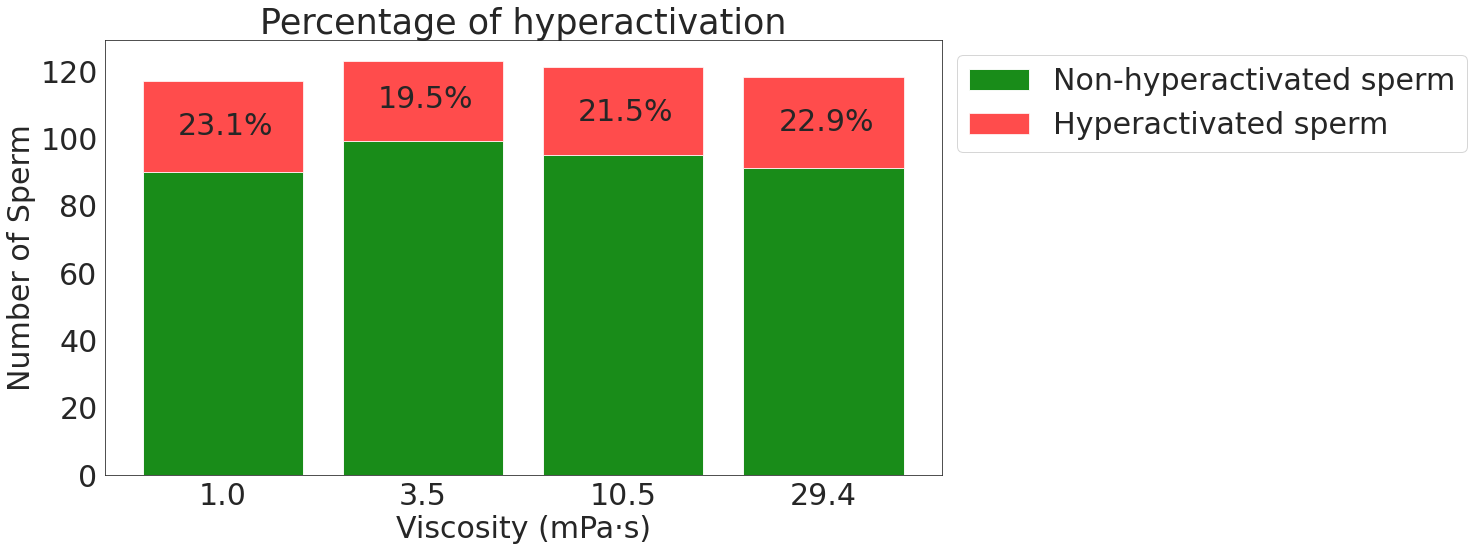

In [41]:
from seaborn.rcmod import set_style
vis=['1.0','3.5','10.5','29.4']
hy=[len(mm_pca_HTF_0p0)-sum(kmeans.predict(mm_pca_HTF_0p0)),len(mm_pca_HTF_0p2)-sum(kmeans.predict(mm_pca_HTF_0p2)),len(mm_pca_HTF_0p4)-sum(kmeans.predict(mm_pca_HTF_0p4)),len(mm_pca_HTF_0p6)-sum(kmeans.predict(mm_pca_HTF_0p6))]
nhy=[sum(kmeans.predict(mm_pca_HTF_0p0)),sum(kmeans.predict(mm_pca_HTF_0p2)),sum(kmeans.predict(mm_pca_HTF_0p4)),sum(kmeans.predict(mm_pca_HTF_0p6))]
x=np.arange(len(vis))
sns.set_style('white')
plt.figure(figsize=(15,8))
plt.bar(x, nhy, color='g', label='Non-hyperactivated sperm',alpha=0.9)
plt.bar(x, hy, color='r', label='Hyperactivated sperm',alpha=0.7, bottom=nhy)
for i in range(len(hy)):
  plt.annotate((str(round(hy[i]/(hy[i]+nhy[i])*100,1))+'%'),(x[i],(hy[i]//3+nhy[i])),textcoords="offset points",xytext=(-45,7),size=30)
plt.xticks(x, vis,size=30)
plt.yticks(size=30)
plt.xlabel('Viscosity (mPa·s)',fontsize=30)
plt.ylabel('Number of Sperm',fontsize=30)
plt.title('Percentage of hyperactivation',fontsize=35)
plt.legend(bbox_to_anchor=(1,1),fontsize=30)
plt.savefig('/content/drive/MyDrive/071422_sperm_mod/Vis_Res_HyperRate',bbox_inches='tight',dpi=300)
plt.show()

# In-vivo data fit the model

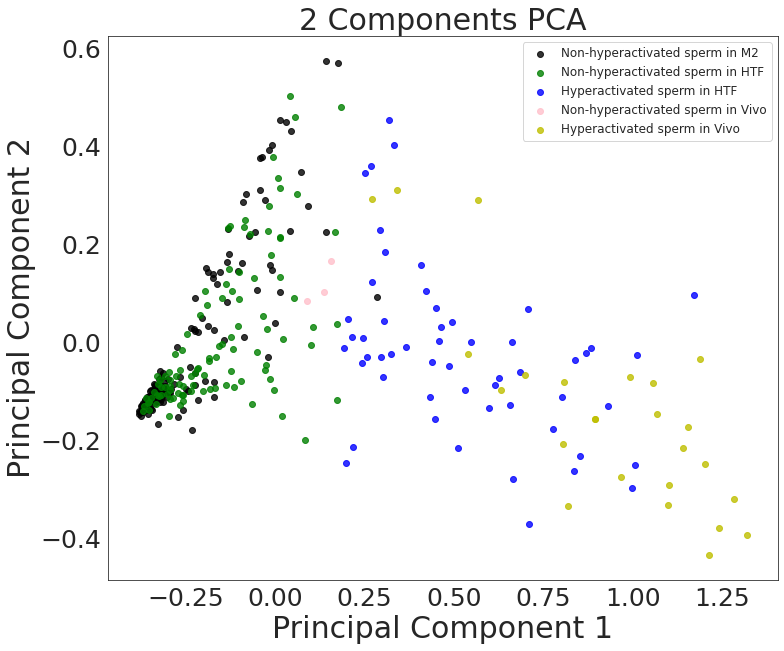

In [42]:
hyidx=[]
nhyidx=[]
sns.set_style('white')
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(1,1,1)
ax.set_title('2 Components PCA', fontsize = 30)
kmeans = KMeans(n_clusters=2,random_state=0).fit(mm_pca_HTF_non)
kdot=ax.scatter(principalDF_all.loc[:seg[0],'principal component 1'],principalDF_all.loc[:seg[0],'principal component 2'],c='k',alpha=0.8)
for i,j in enumerate(kmeans.labels_):
    if j==0:
        bdot=ax.scatter(principalDF_all.loc[seg[0]+i,'principal component 1'],principalDF_all.loc[seg[0]+i,'principal component 2'],c='b',alpha=0.8)
        hyidx.append(seg[0]+i)
    else:
        gdot=ax.scatter(principalDF_all.loc[seg[0]+i,'principal component 1'],principalDF_all.loc[seg[0]+i,'principal component 2'],c='g',alpha=0.8)
        nhyidx.append(seg[0]+i)
for i,j in enumerate(kmeans.predict(mm_pca_invivo)):
    if j==0:
        ydot=ax.scatter(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2'],c='y',alpha=0.8)
    else:
        pdot=ax.scatter(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2'],c='pink',alpha=0.8)
ax.set_xlabel('Principal Component 1', fontsize = 30)
ax.set_ylabel('Principal Component 2', fontsize = 30)
ax.yaxis.set_tick_params(labelsize=25)
ax.xaxis.set_tick_params(labelsize=25)
ax.legend([kdot,gdot,bdot,pdot,ydot],['Non-hyperactivated sperm in M2','Non-hyperactivated sperm in HTF','Hyperactivated sperm in HTF','Non-hyperactivated sperm in Vivo','Hyperactivated sperm in Vivo'],fontsize=12)
plt.savefig('/content/drive/MyDrive/071422_sperm_mod/PCA_Kmean')
plt.show()

In [43]:
kmeans.predict(mm_pca_invivo),100-sum(kmeans.predict(mm_pca_invivo))/len(kmeans.predict(mm_pca_invivo))*100

(array([1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], dtype=int32), 89.28571428571429)

# **SwarmPlot over numerous parameters**

In [44]:
df_mod_ntc=principalDF_all.iloc[:seg[0]]
df_mod_hy=principalDF_all.iloc[hyidx]
df_mod_nhy=principalDF_all.iloc[nhyidx]

In [45]:
ntcPara,hyPara,nhyPara=[],[],[]
for e in ['SDofDV','LIN','STR','WOB']:
  for _ in range(len(hyidx)):
    hyPara.append(e)
  for _ in range(len(nhyidx)):
    nhyPara.append(e)
  for _ in range(len(df_mod_ntc)):
    ntcPara.append(e)

In [46]:
df_reshaped_ntc=pd.DataFrame(data={'Percentage':pd.concat([df_mod_ntc['SDofDV'],df_mod_ntc['LIN'],df_mod_ntc['STR'],df_mod_ntc['WOB']],ignore_index=True),'Paras':ntcPara,'Med':['M2']*(4*len(df_mod_ntc)),'Hy':[0]*(4*len(df_mod_ntc))})
df_reshaped_hy=pd.DataFrame(data={'Percentage':pd.concat([df_mod_hy['SDofDV'],df_mod_hy['LIN'],df_mod_hy['STR'],df_mod_hy['WOB']],ignore_index=True),'Paras':hyPara,'Med':['HTF']*(4*len(df_mod_hy)),'Hy':[1]*(4*len(df_mod_hy))})
df_reshaped_nhy=pd.DataFrame(data={'Percentage':pd.concat([df_mod_nhy['SDofDV'],df_mod_nhy['LIN'],df_mod_nhy['STR'],df_mod_nhy['WOB']],ignore_index=True),'Paras':nhyPara,'Med':['HTF']*(4*len(df_mod_nhy)),'Hy':[0]*(4*len(df_mod_nhy))})

In [47]:
df_swarm1=pd.concat([df_reshaped_ntc.loc[[i for i in range(len(df_reshaped_ntc)) if i%2==0]],df_reshaped_hy])
df_swarm2=pd.concat([df_reshaped_ntc.loc[[i for i in range(len(df_reshaped_ntc)) if i%2!=0]],df_reshaped_nhy])

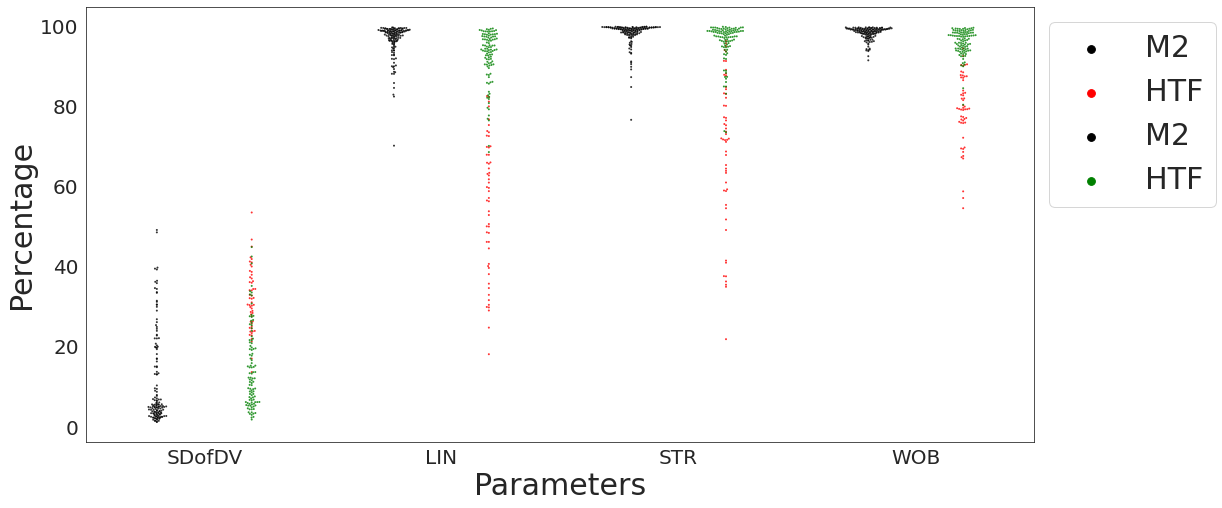

In [48]:
fig = plt.figure(figsize = (17,8))
sns.swarmplot(x ="Paras", y = "Percentage", hue="Med", data = df_swarm1, size = 2, palette=["k","r"],alpha=0.8, dodge=True)
sns.swarmplot(x ="Paras", y = "Percentage", hue="Med", data = df_swarm2, size = 2, palette=["k","g"],alpha=0.8, dodge=True)
plt.xlabel('Parameters',fontsize=30)
plt.ylabel('Percentage',fontsize=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(bbox_to_anchor=(1,1),fontsize=30)
plt.savefig("/content/drive/MyDrive/071422_sperm_mod/Kmean_swarm_plot")
plt.show()

# **Model DataSet BreakDown**

In [49]:
spn_mod=[57,49,53] #[set 1,set 2,set 3]

In [50]:
modBreakDown=[57,106]

In [51]:
Kmeans_1=kmeans.predict(mm_pca_HTF_non[:modBreakDown[0]])
Kmeans_2=kmeans.predict(mm_pca_HTF_non[modBreakDown[0]:modBreakDown[1]])
Kmeans_3=kmeans.predict(mm_pca_HTF_non[modBreakDown[1]:])

In [52]:
Kmeans_1,Kmeans_2,Kmeans_3

(array([1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32),
 array([0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 1, 0], dtype=int32),
 array([0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 0, 1, 0, 0, 1, 0, 0], dtype=int32))

In [53]:
100-sum(Kmeans_1)/spn_mod[0]*100,100-sum(Kmeans_2)/spn_mod[1]*100,100-sum(Kmeans_3)/spn_mod[2]*100

(24.56140350877193, 42.85714285714286, 35.84905660377359)

# **VisExpDataSet BreakDown**

In [54]:
# [38,43,36,37] [0p0,0p2,0p4,0p6] Set 1
# [42,42,35,41] [0p0,0p2,0p4,0p6] Set 2
# [37,38,50,40] [0p0,0p2,0p4,0p6] Set 3
visSeg1=[38,43,36,37]
visSeg2=[80,85,71,78]

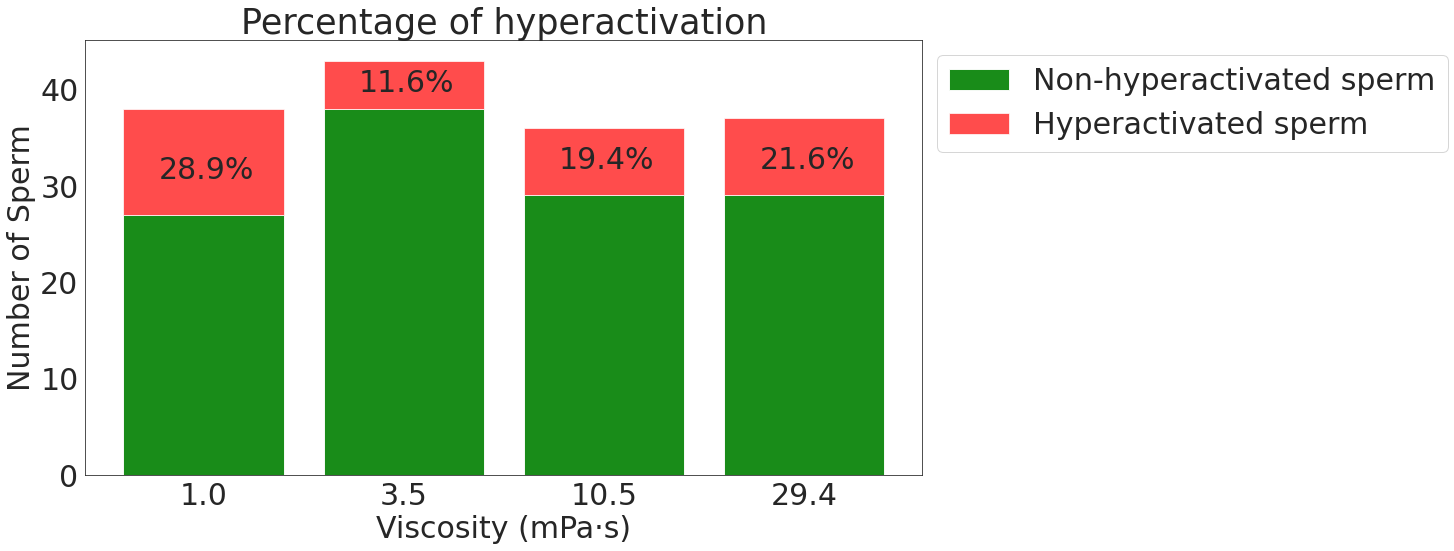

In [55]:
from seaborn.rcmod import set_style
vis=['1.0','3.5','10.5','29.4']
hy=[len(mm_pca_HTF_0p0[:visSeg1[0]])-sum(kmeans.predict(mm_pca_HTF_0p0[:visSeg1[0]])),len(mm_pca_HTF_0p2[:visSeg1[1]])-sum(kmeans.predict(mm_pca_HTF_0p2[:visSeg1[1]])),len(mm_pca_HTF_0p4[:visSeg1[2]])-sum(kmeans.predict(mm_pca_HTF_0p4[:visSeg1[2]])),len(mm_pca_HTF_0p6[:visSeg1[3]])-sum(kmeans.predict(mm_pca_HTF_0p6[:visSeg1[3]]))]
nhy=[sum(kmeans.predict(mm_pca_HTF_0p0[:visSeg1[0]])),sum(kmeans.predict(mm_pca_HTF_0p2[:visSeg1[1]])),sum(kmeans.predict(mm_pca_HTF_0p4[:visSeg1[2]])),sum(kmeans.predict(mm_pca_HTF_0p6[:visSeg1[3]]))]
x=np.arange(len(vis))
sns.set_style('white')
plt.figure(figsize=(15,8))
plt.bar(x, nhy, color='g', label='Non-hyperactivated sperm',alpha=0.9)
plt.bar(x, hy, color='r', label='Hyperactivated sperm',alpha=0.7, bottom=nhy)
for i in range(len(hy)):
  plt.annotate((str(round(hy[i]/(hy[i]+nhy[i])*100,1))+'%'),(x[i],(hy[i]//3+nhy[i])),textcoords="offset points",xytext=(-45,7),size=30)
plt.xticks(x, vis,size=30)
plt.yticks(size=30)
plt.xlabel('Viscosity (mPa·s)',fontsize=30)
plt.ylabel('Number of Sperm',fontsize=30)
plt.title('Percentage of hyperactivation',fontsize=35)
plt.legend(bbox_to_anchor=(1,1),fontsize=30)
plt.savefig('/content/drive/MyDrive/071422_sperm_mod/Vis_Res_HyperRate_1',bbox_inches='tight',dpi=300)
plt.show()

In [56]:
hy

[11, 5, 7, 8]

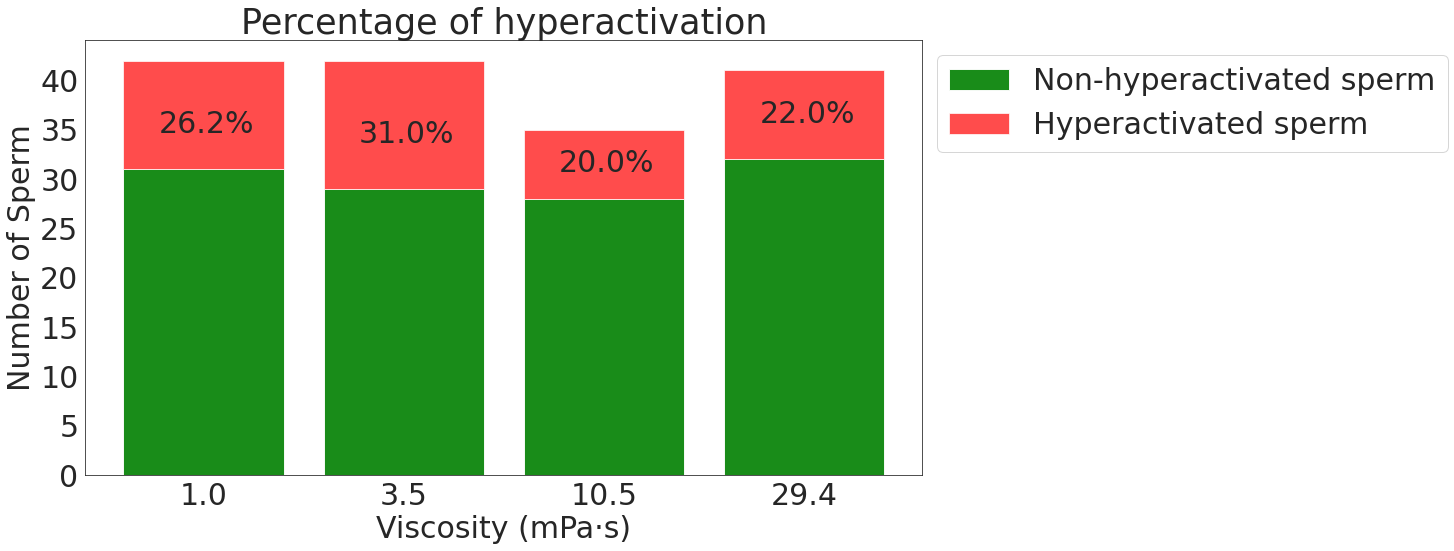

In [57]:
from seaborn.rcmod import set_style
vis=['1.0','3.5','10.5','29.4']
hy=[len(mm_pca_HTF_0p0[visSeg1[0]:visSeg2[0]])-sum(kmeans.predict(mm_pca_HTF_0p0[visSeg1[0]:visSeg2[0]])),len(mm_pca_HTF_0p2[visSeg1[1]:visSeg2[1]])-sum(kmeans.predict(mm_pca_HTF_0p2[visSeg1[1]:visSeg2[1]])),len(mm_pca_HTF_0p4[visSeg1[2]:visSeg2[2]])-sum(kmeans.predict(mm_pca_HTF_0p4[visSeg1[2]:visSeg2[2]])),len(mm_pca_HTF_0p6[visSeg1[3]:visSeg2[3]])-sum(kmeans.predict(mm_pca_HTF_0p6[visSeg1[3]:visSeg2[3]]))]
nhy=[sum(kmeans.predict(mm_pca_HTF_0p0[visSeg1[0]:visSeg2[0]])),sum(kmeans.predict(mm_pca_HTF_0p2[visSeg1[1]:visSeg2[1]])),sum(kmeans.predict(mm_pca_HTF_0p4[visSeg1[2]:visSeg2[2]])),sum(kmeans.predict(mm_pca_HTF_0p6[visSeg1[3]:visSeg2[3]]))]
x=np.arange(len(vis))
sns.set_style('white')
plt.figure(figsize=(15,8))
plt.bar(x, nhy, color='g', label='Non-hyperactivated sperm',alpha=0.9)
plt.bar(x, hy, color='r', label='Hyperactivated sperm',alpha=0.7, bottom=nhy)
for i in range(len(hy)):
  plt.annotate((str(round(hy[i]/(hy[i]+nhy[i])*100,1))+'%'),(x[i],(hy[i]//3+nhy[i])),textcoords="offset points",xytext=(-45,7),size=30)
plt.xticks(x, vis,size=30)
plt.yticks(size=30)
plt.xlabel('Viscosity (mPa·s)',fontsize=30)
plt.ylabel('Number of Sperm',fontsize=30)
plt.title('Percentage of hyperactivation',fontsize=35)
plt.legend(bbox_to_anchor=(1,1),fontsize=30)
plt.savefig('/content/drive/MyDrive/071422_sperm_mod/Vis_Res_HyperRate_2',bbox_inches='tight',dpi=300)
plt.show()

In [58]:
hy

[11, 13, 7, 9]

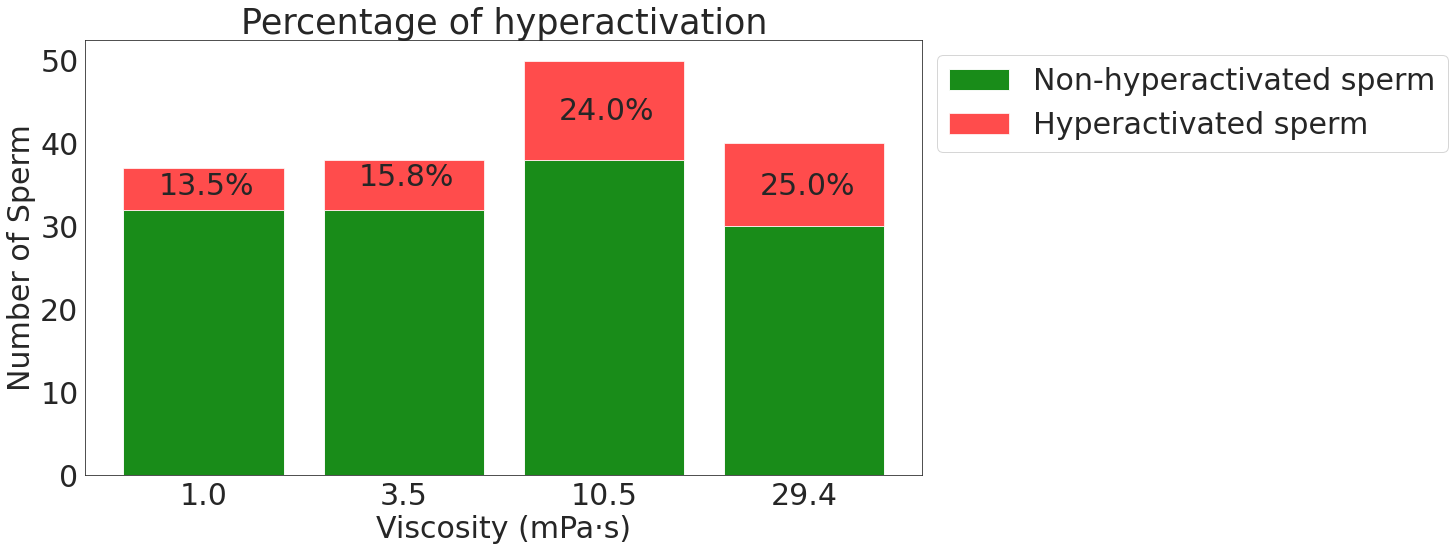

In [59]:
from seaborn.rcmod import set_style
vis=['1.0','3.5','10.5','29.4']
hy=[len(mm_pca_HTF_0p0[visSeg2[0]:])-sum(kmeans.predict(mm_pca_HTF_0p0[visSeg2[0]:])),len(mm_pca_HTF_0p2[visSeg2[1]:])-sum(kmeans.predict(mm_pca_HTF_0p2[visSeg2[1]:])),len(mm_pca_HTF_0p4[visSeg2[2]:])-sum(kmeans.predict(mm_pca_HTF_0p4[visSeg2[2]:])),len(mm_pca_HTF_0p6[visSeg2[3]:])-sum(kmeans.predict(mm_pca_HTF_0p6[visSeg2[3]:]))]
nhy=[sum(kmeans.predict(mm_pca_HTF_0p0[visSeg2[0]:])),sum(kmeans.predict(mm_pca_HTF_0p2[visSeg2[1]:])),sum(kmeans.predict(mm_pca_HTF_0p4[visSeg2[2]:])),sum(kmeans.predict(mm_pca_HTF_0p6[visSeg2[3]:]))]
x=np.arange(len(vis))
sns.set_style('white')
plt.figure(figsize=(15,8))
plt.bar(x, nhy, color='g', label='Non-hyperactivated sperm',alpha=0.9)
plt.bar(x, hy, color='r', label='Hyperactivated sperm',alpha=0.7, bottom=nhy)
for i in range(len(hy)):
  plt.annotate((str(round(hy[i]/(hy[i]+nhy[i])*100,1))+'%'),(x[i],(hy[i]//3+nhy[i])),textcoords="offset points",xytext=(-45,7),size=30)
plt.xticks(x, vis,size=30)
plt.yticks(size=30)
plt.xlabel('Viscosity (mPa·s)',fontsize=30)
plt.ylabel('Number of Sperm',fontsize=30)
plt.title('Percentage of hyperactivation',fontsize=35)
plt.legend(bbox_to_anchor=(1,1),fontsize=30)
plt.savefig('/content/drive/MyDrive/071422_sperm_mod/Vis_Res_HyperRate_3',bbox_inches='tight',dpi=300)
plt.show()

In [60]:
hy

[5, 6, 12, 10]

# Model built by 0p0-viscosity data from three mice

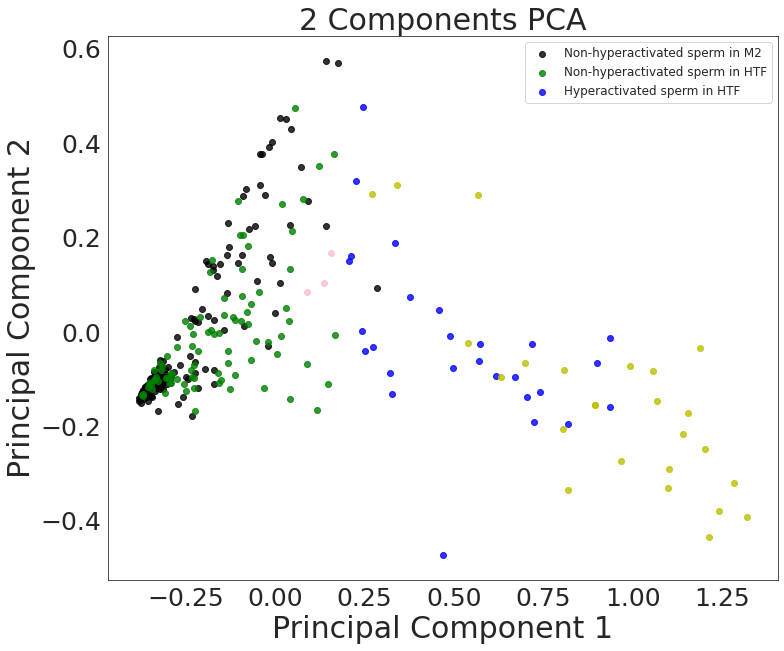

In [61]:
hyidx_0p0=[]
nhyidx_0p0=[]
sns.set_style('white')
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(1,1,1)
ax.set_title('2 Components PCA', fontsize = 30)
kmeans = KMeans(n_clusters=2,random_state=0).fit(mm_pca_HTF_0p0)
kdot=ax.scatter(principalDF_all.loc[:seg[0],'principal component 1'],principalDF_all.loc[:seg[0],'principal component 2'],c='k',alpha=0.8)
for i,j in enumerate(kmeans.labels_):
    if j==0:
        bdot=ax.scatter(principalDF_all.loc[seg[2]+i,'principal component 1'],principalDF_all.loc[seg[2]+i,'principal component 2'],c='b',alpha=0.8)
        hyidx_0p0.append(seg[2]+i)
    else:
        gdot=ax.scatter(principalDF_all.loc[seg[2]+i,'principal component 1'],principalDF_all.loc[seg[2]+i,'principal component 2'],c='g',alpha=0.8)
        nhyidx_0p0.append(seg[2]+i)
for i,j in enumerate(kmeans.predict(mm_pca_invivo)):
    if j==0:
        ydot=ax.scatter(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2'],c='y',alpha=0.8)
    else:
        pdot=ax.scatter(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2'],c='pink',alpha=0.8)
ax.set_xlabel('Principal Component 1', fontsize = 30)
ax.set_ylabel('Principal Component 2', fontsize = 30)
ax.yaxis.set_tick_params(labelsize=25)
ax.xaxis.set_tick_params(labelsize=25)
ax.legend([kdot,gdot,bdot],['Non-hyperactivated sperm in M2','Non-hyperactivated sperm in HTF','Hyperactivated sperm in HTF'],fontsize=12)
plt.savefig('/content/drive/MyDrive/071422_sperm_mod/PCA_Kmean_mod_0p0')
plt.show()

In [62]:
len(hyidx_0p0),len(nhyidx_0p0),len(hyidx_0p0)/(len(hyidx_0p0)+len(nhyidx_0p0))*100

(27, 90, 23.076923076923077)

# Model built by 0p2-viscosity data from three mice

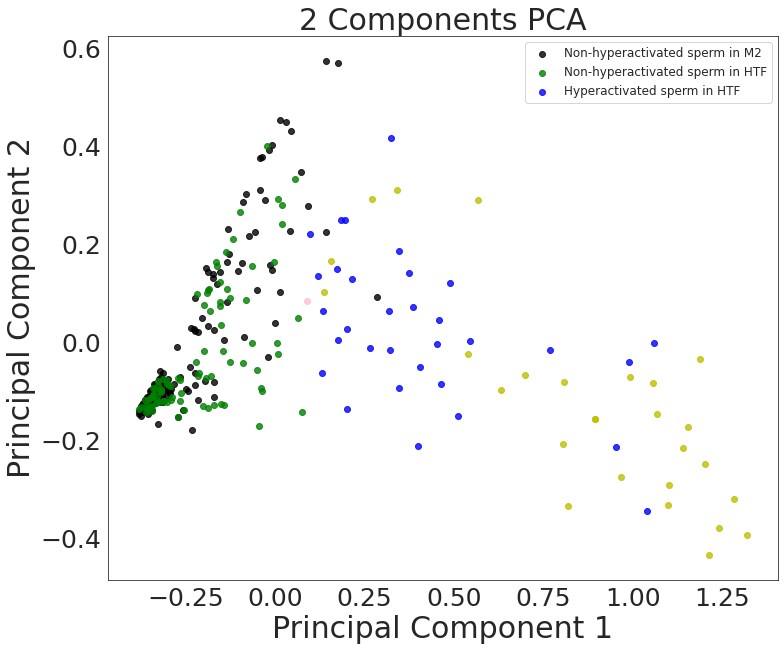

In [63]:
hyidx_0p2=[]
nhyidx_0p2=[]
sns.set_style('white')
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(1,1,1)
ax.set_title('2 Components PCA', fontsize = 30)
kmeans = KMeans(n_clusters=2,random_state=0).fit(mm_pca_HTF_0p2)
kdot=ax.scatter(principalDF_all.loc[:seg[0],'principal component 1'],principalDF_all.loc[:seg[0],'principal component 2'],c='k',alpha=0.8)
for i,j in enumerate(kmeans.labels_):
    if j==1:
        bdot=ax.scatter(principalDF_all.loc[seg[3]+i,'principal component 1'],principalDF_all.loc[seg[3]+i,'principal component 2'],c='b',alpha=0.8)
        hyidx_0p2.append(seg[3]+i)
    else:
        gdot=ax.scatter(principalDF_all.loc[seg[3]+i,'principal component 1'],principalDF_all.loc[seg[3]+i,'principal component 2'],c='g',alpha=0.8)
        nhyidx_0p2.append(seg[3]+i)
for i,j in enumerate(kmeans.predict(mm_pca_invivo)):
    if j==1:
        ydot=ax.scatter(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2'],c='y',alpha=0.8)
    else:
        pdot=ax.scatter(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2'],c='pink',alpha=0.8)
ax.set_xlabel('Principal Component 1', fontsize = 30)
ax.set_ylabel('Principal Component 2', fontsize = 30)
ax.yaxis.set_tick_params(labelsize=25)
ax.xaxis.set_tick_params(labelsize=25)
ax.legend([kdot,gdot,bdot],['Non-hyperactivated sperm in M2','Non-hyperactivated sperm in HTF','Hyperactivated sperm in HTF'],fontsize=12)
plt.savefig('/content/drive/MyDrive/071422_sperm_mod/PCA_Kmean_mod_0p2')
plt.show()

In [64]:
len(hyidx_0p2),len(nhyidx_0p2),len(hyidx_0p2)/(len(hyidx_0p2)+len(nhyidx_0p2))*100

(32, 91, 26.01626016260163)

# Model built by 0p4-viscosity data from three mice

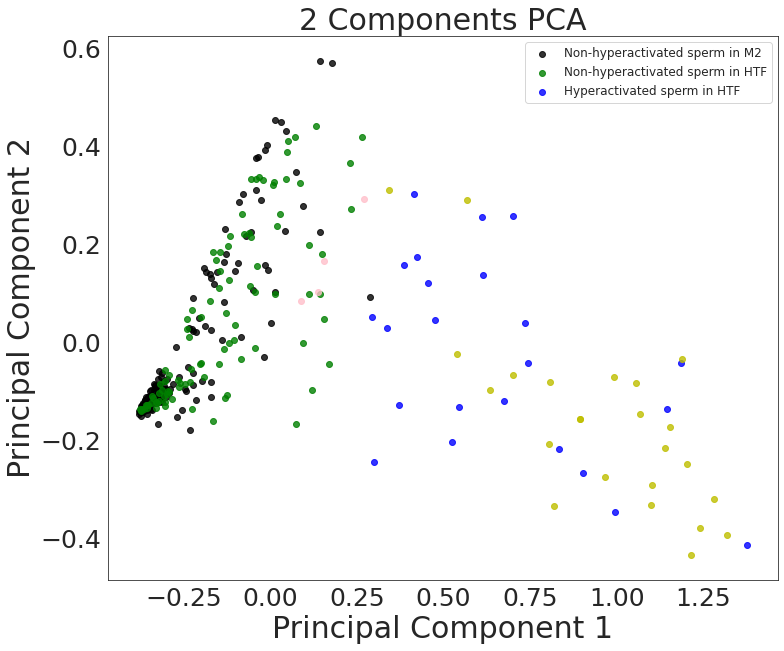

In [65]:
hyidx_0p4=[]
nhyidx_0p4=[]
sns.set_style('white')
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(1,1,1)
ax.set_title('2 Components PCA', fontsize = 30)
kmeans = KMeans(n_clusters=2,random_state=0).fit(mm_pca_HTF_0p4)
kdot=ax.scatter(principalDF_all.loc[:seg[0],'principal component 1'],principalDF_all.loc[:seg[0],'principal component 2'],c='k',alpha=0.8)
for i,j in enumerate(kmeans.labels_):
    if j==1:
        bdot=ax.scatter(principalDF_all.loc[seg[4]+i,'principal component 1'],principalDF_all.loc[seg[4]+i,'principal component 2'],c='b',alpha=0.8)
        hyidx_0p4.append(seg[4]+i)
    else:
        gdot=ax.scatter(principalDF_all.loc[seg[4]+i,'principal component 1'],principalDF_all.loc[seg[4]+i,'principal component 2'],c='g',alpha=0.8)
        nhyidx_0p4.append(seg[4]+i)
for i,j in enumerate(kmeans.predict(mm_pca_invivo)):
    if j==1:
        ydot=ax.scatter(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2'],c='y',alpha=0.8)
    else:
        pdot=ax.scatter(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2'],c='pink',alpha=0.8)
ax.set_xlabel('Principal Component 1', fontsize = 30)
ax.set_ylabel('Principal Component 2', fontsize = 30)
ax.yaxis.set_tick_params(labelsize=25)
ax.xaxis.set_tick_params(labelsize=25)
ax.legend([kdot,gdot,bdot],['Non-hyperactivated sperm in M2','Non-hyperactivated sperm in HTF','Hyperactivated sperm in HTF'],fontsize=12)
plt.savefig('/content/drive/MyDrive/071422_sperm_mod/PCA_Kmean_mod_0p4')
plt.show()

In [66]:
len(hyidx_0p4),len(nhyidx_0p4),len(hyidx_0p4)/(len(hyidx_0p4)+len(nhyidx_0p4))*100

(23, 98, 19.00826446280992)

# Model built by 0p6-viscosity data from three mice

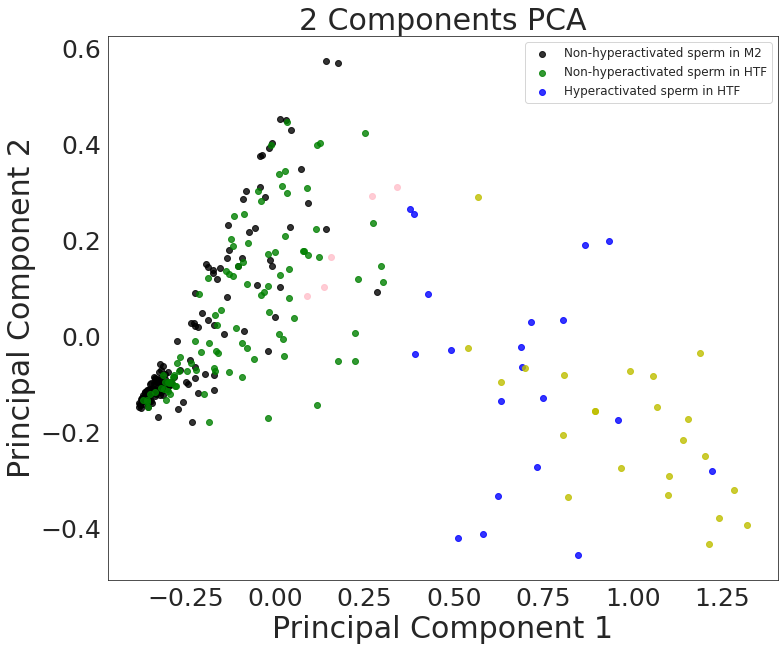

In [67]:
hyidx_0p6=[]
nhyidx_0p6=[]
sns.set_style('white')
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(1,1,1)
ax.set_title('2 Components PCA', fontsize = 30)
kmeans = KMeans(n_clusters=2,random_state=0).fit(mm_pca_HTF_0p6)
kdot=ax.scatter(principalDF_all.loc[:seg[0],'principal component 1'],principalDF_all.loc[:seg[0],'principal component 2'],c='k',alpha=0.8)
for i,j in enumerate(kmeans.labels_):
    if j==1:
        bdot=ax.scatter(principalDF_all.loc[seg[5]+i,'principal component 1'],principalDF_all.loc[seg[5]+i,'principal component 2'],c='b',alpha=0.8)
        hyidx_0p6.append(seg[4]+i)
    else:
        gdot=ax.scatter(principalDF_all.loc[seg[5]+i,'principal component 1'],principalDF_all.loc[seg[5]+i,'principal component 2'],c='g',alpha=0.8)
        nhyidx_0p6.append(seg[4]+i)
for i,j in enumerate(kmeans.predict(mm_pca_invivo)):
    if j==1:
        ydot=ax.scatter(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2'],c='y',alpha=0.8)
    else:
        pdot=ax.scatter(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2'],c='pink',alpha=0.8)
ax.set_xlabel('Principal Component 1', fontsize = 30)
ax.set_ylabel('Principal Component 2', fontsize = 30)
ax.yaxis.set_tick_params(labelsize=25)
ax.xaxis.set_tick_params(labelsize=25)
ax.legend([kdot,gdot,bdot],['Non-hyperactivated sperm in M2','Non-hyperactivated sperm in HTF','Hyperactivated sperm in HTF'],fontsize=12)
plt.savefig('/content/drive/MyDrive/071422_sperm_mod/PCA_Kmean_mod_0p6')
plt.show()

In [68]:
len(hyidx_0p6),len(nhyidx_0p6),len(hyidx_0p6)/(len(hyidx_0p6)+len(nhyidx_0p6))*100

(20, 98, 16.94915254237288)

# **Invivo Trajectories demo in 2D projections and 3D**

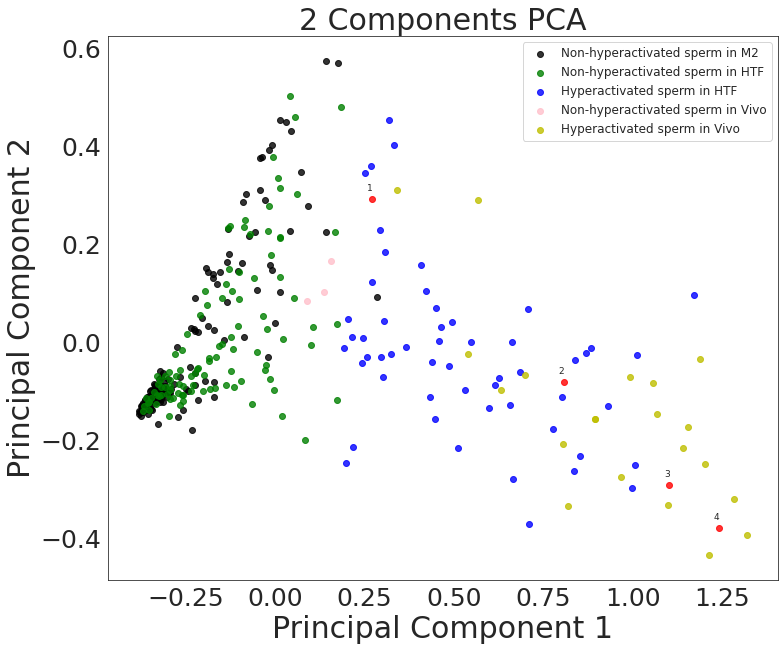

In [69]:
hyidx=[]
nhyidx=[]
sns.set_style('white')
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(1,1,1)
ax.set_title('2 Components PCA', fontsize = 30)
kmeans = KMeans(n_clusters=2,random_state=0).fit(mm_pca_HTF_non)
kdot=ax.scatter(principalDF_all.loc[:seg[0],'principal component 1'],principalDF_all.loc[:seg[0],'principal component 2'],c='k',alpha=0.8)
for i,j in enumerate(kmeans.labels_):
    if j==0:
        bdot=ax.scatter(principalDF_all.loc[seg[0]+i,'principal component 1'],principalDF_all.loc[seg[0]+i,'principal component 2'],c='b',alpha=0.8)
        hyidx.append(seg[0]+i)
    else:
        gdot=ax.scatter(principalDF_all.loc[seg[0]+i,'principal component 1'],principalDF_all.loc[seg[0]+i,'principal component 2'],c='g',alpha=0.8)
        nhyidx.append(seg[0]+i)
dic={5:1,14:2,7:3,13:4}
for i,j in enumerate(kmeans.predict(mm_pca_invivo)):
    if j==0:
      if i+1 in dic:
        rdot=ax.scatter(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2'],c='r',alpha=0.8)
        ax.annotate(dic[i+1],(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2']),textcoords="offset points",xytext=(-5,8),size=9)
      else:
        ydot=ax.scatter(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2'],c='y',alpha=0.8)
    else:
        pdot=ax.scatter(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2'],c='pink',alpha=0.8)
ax.set_xlabel('Principal Component 1', fontsize = 30)
ax.set_ylabel('Principal Component 2', fontsize = 30)
ax.yaxis.set_tick_params(labelsize=25)
ax.xaxis.set_tick_params(labelsize=25)
ax.legend([kdot,gdot,bdot,pdot,ydot],['Non-hyperactivated sperm in M2','Non-hyperactivated sperm in HTF','Hyperactivated sperm in HTF','Non-hyperactivated sperm in Vivo','Hyperactivated sperm in Vivo'],fontsize=12)
plt.savefig('/content/drive/MyDrive/071422_sperm_mod/PCA_Kmean_select')
plt.show()

In [70]:
df_invivo_5=pd.read_csv('/content/drive/MyDrive/032822_viscosity_statistic/040722_viscosity_statistic/040722_SW_sperm/SW_sperm_invivo_vis_5.csv')
df_invivo_7=pd.read_csv('/content/drive/MyDrive/032822_viscosity_statistic/040722_viscosity_statistic/040722_SW_sperm/SW_sperm_invivo_vis_7.csv')
df_invivo_13=pd.read_csv('/content/drive/MyDrive/032822_viscosity_statistic/040722_viscosity_statistic/040722_SW_sperm/SW_sperm_invivo_vis_13.csv')
df_invivo_14=pd.read_csv('/content/drive/MyDrive/032822_viscosity_statistic/040722_viscosity_statistic/040722_SW_sperm/SW_sperm_invivo_vis_14.csv')

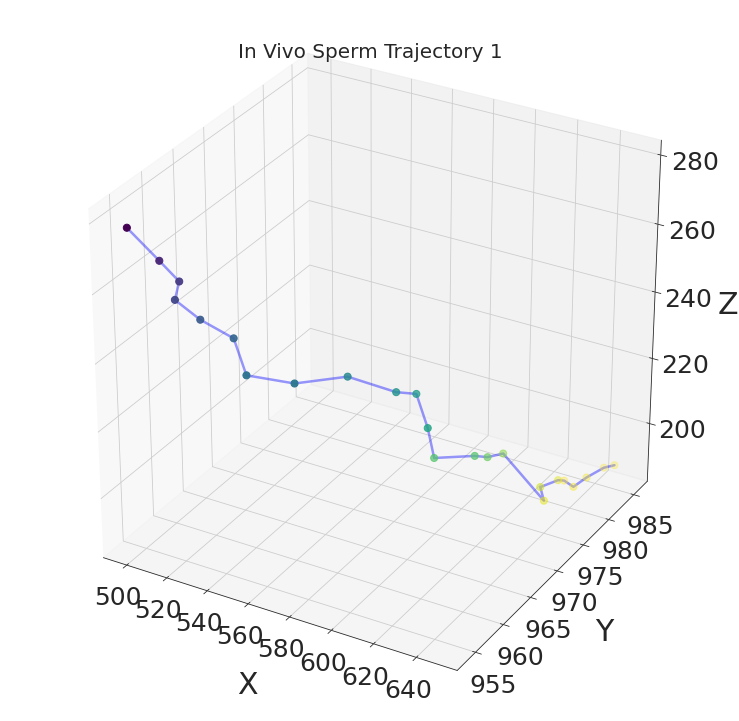

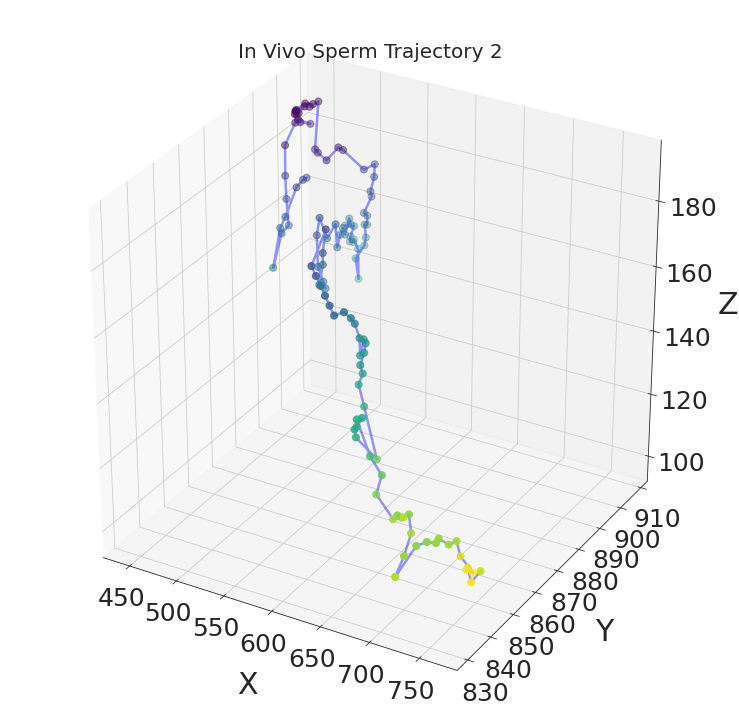

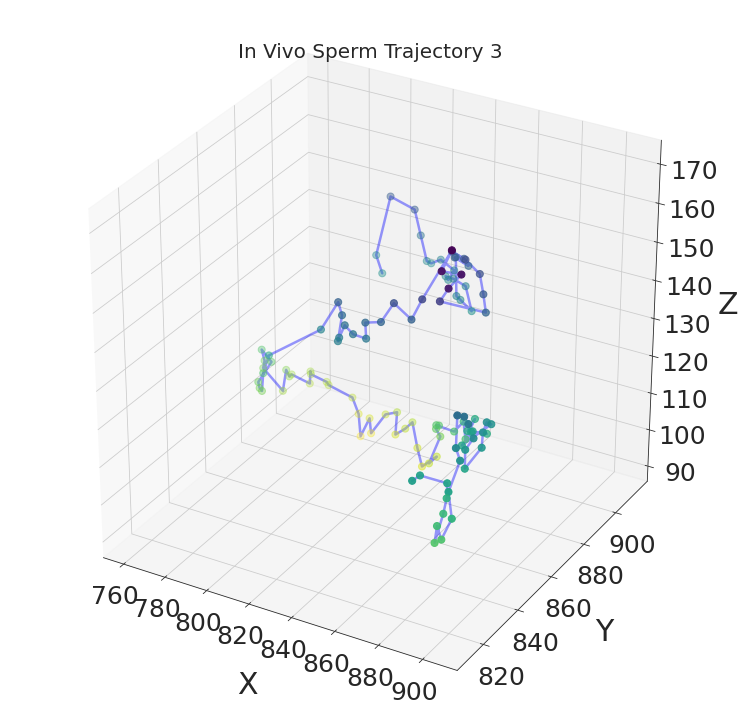

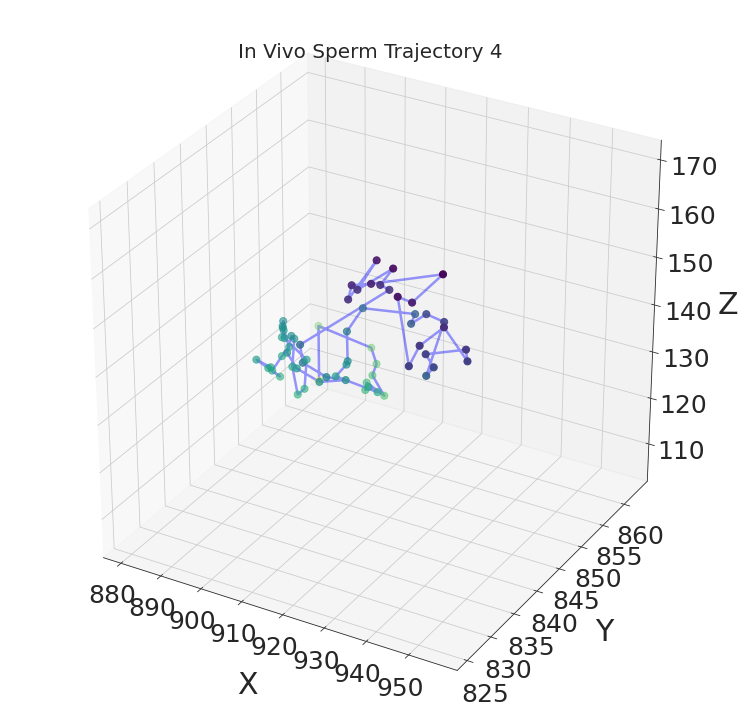

In [71]:
for i,df in enumerate([df_invivo_5,df_invivo_14,df_invivo_7,df_invivo_13]):
  fig = plt.figure(figsize=(13,13))
  sns.set_style('ticks')
  ax = plt.axes(projection='3d')
  xdata,ydata,zdata=df['Position X'],df['Position Y'],df['Position Z']
  ax.scatter3D(xdata,ydata,zdata,c=zdata,cmap='viridis_r',s=50,zorder=2)
  ax.plot(xdata,ydata,zdata,c='blue',linewidth=2.5,zorder=1,alpha=0.4)
  ax.set_xlabel('X',fontsize=30)
  ax.set_ylabel('Y',fontsize=30)
  ax.set_zlabel('Z',fontsize=30)
  ax.xaxis.labelpad=30
  ax.yaxis.labelpad=30
  ax.zaxis.labelpad=30
  ax.xaxis.set_tick_params(labelsize=25,pad=7)
  ax.yaxis.set_tick_params(labelsize=25,pad=10)
  ax.zaxis.set_tick_params(labelsize=25,pad=15)
  ax.set_title('In Vivo Sperm Trajectory {}'.format(i+1),fontsize=20)
  plt.autoscale()
  plt.savefig("/content/drive/MyDrive/071422_sperm_mod/082522_OCT_trj_in_vivo_select/3D_trj_in_vivo_select_{}.png".format(i+1),bbox_inches='tight',dpi=100)
  plt.show()

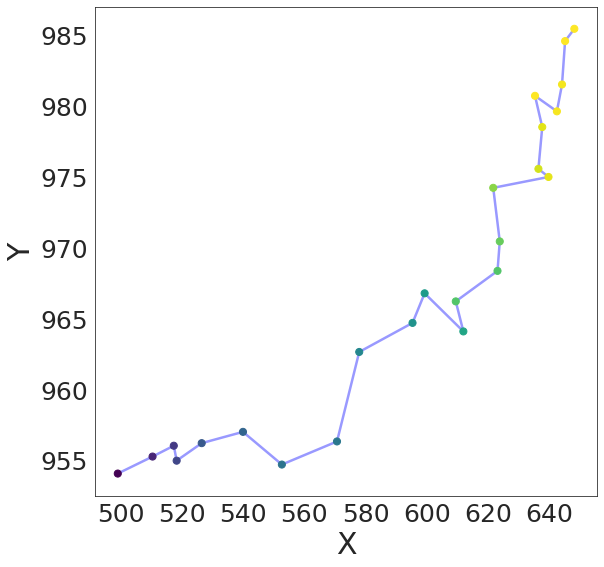

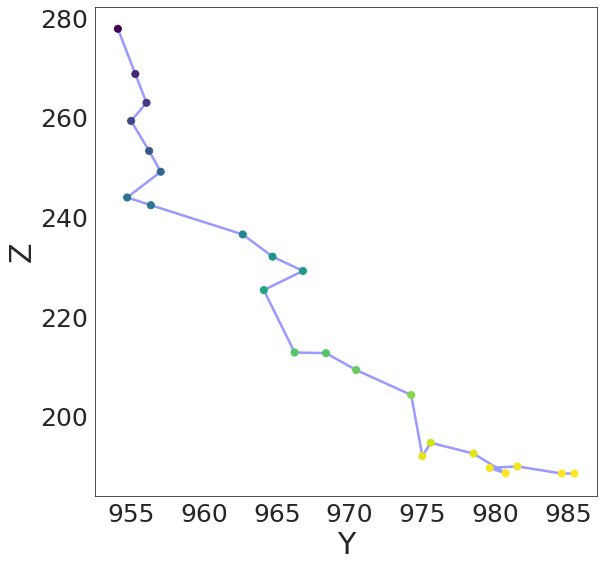

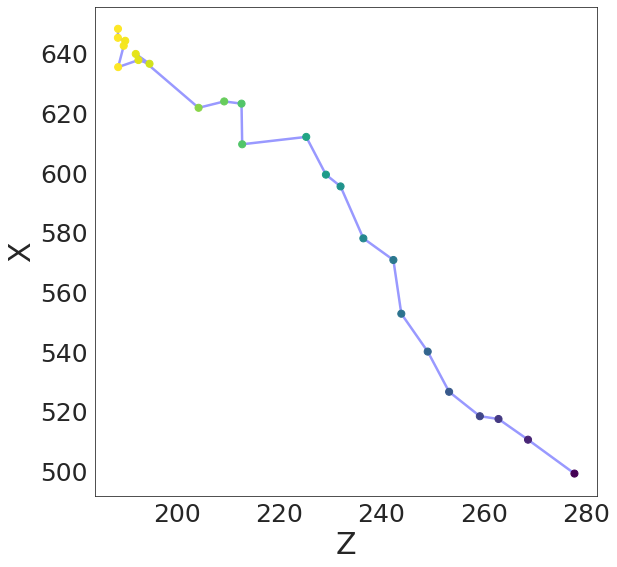

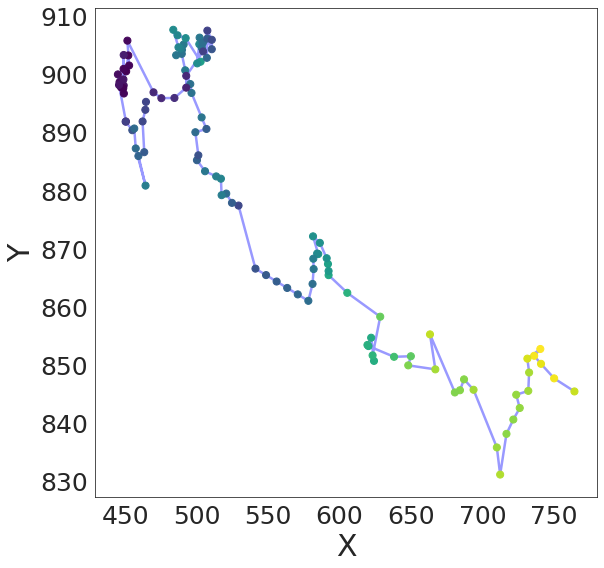

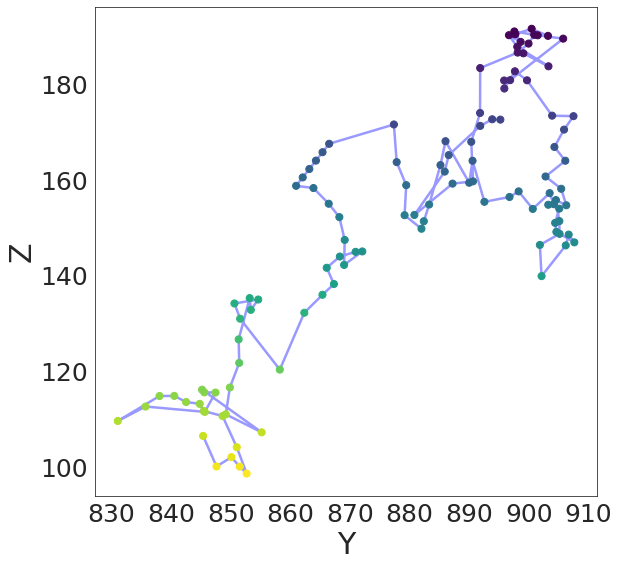

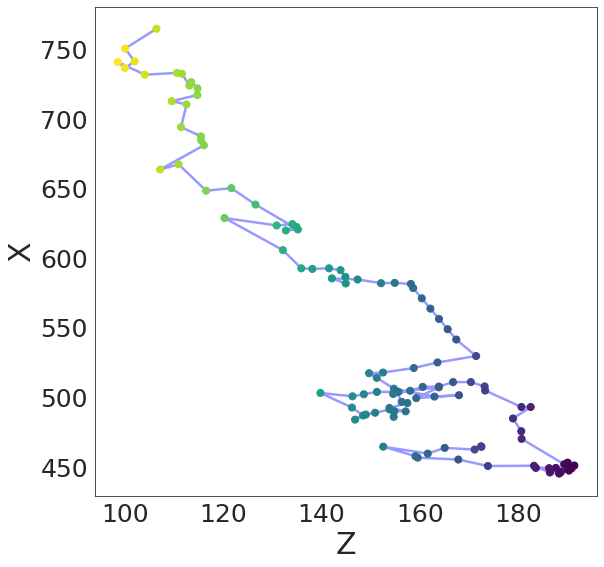

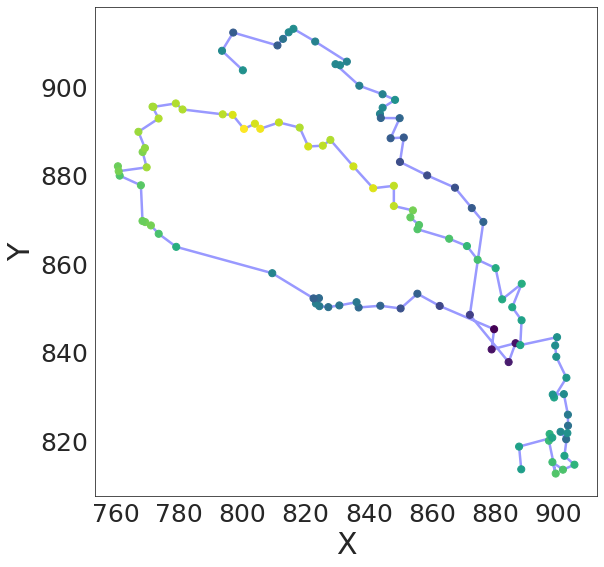

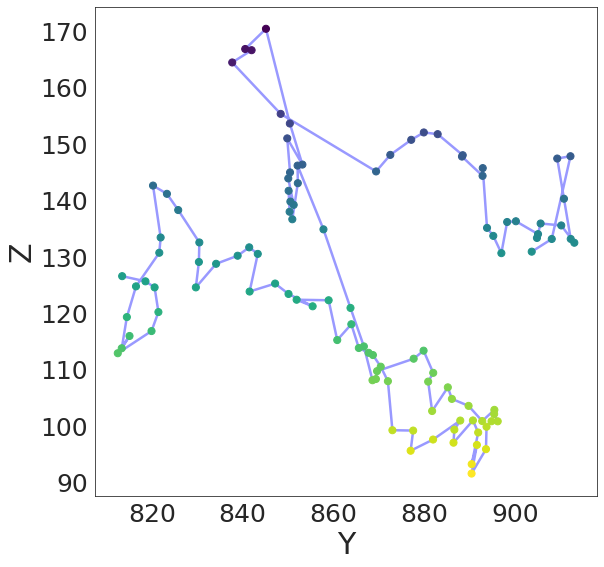

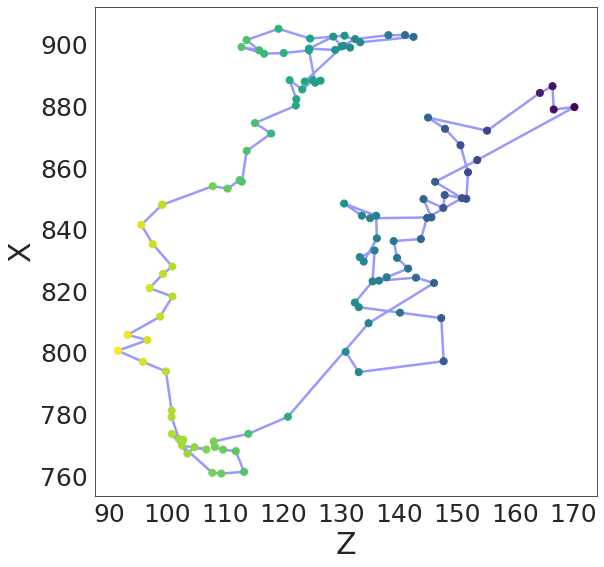

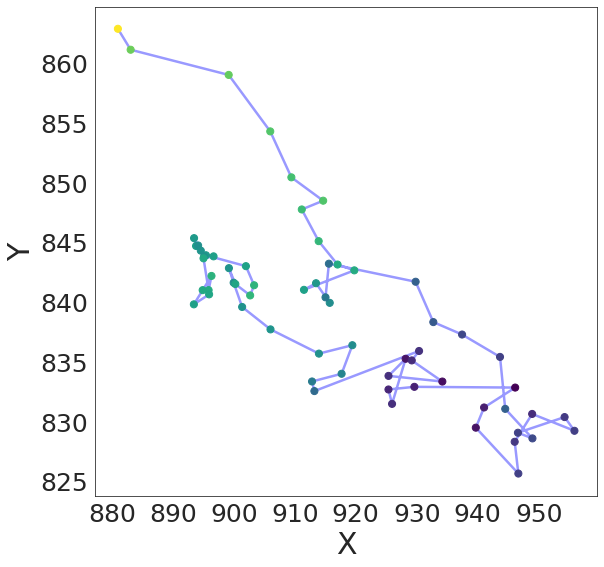

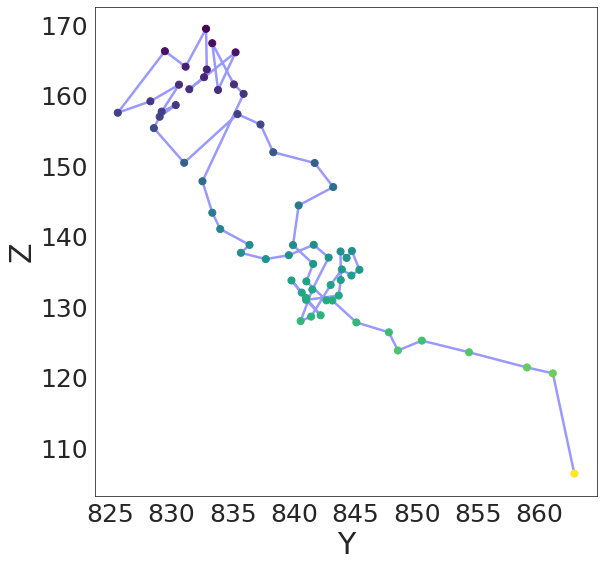

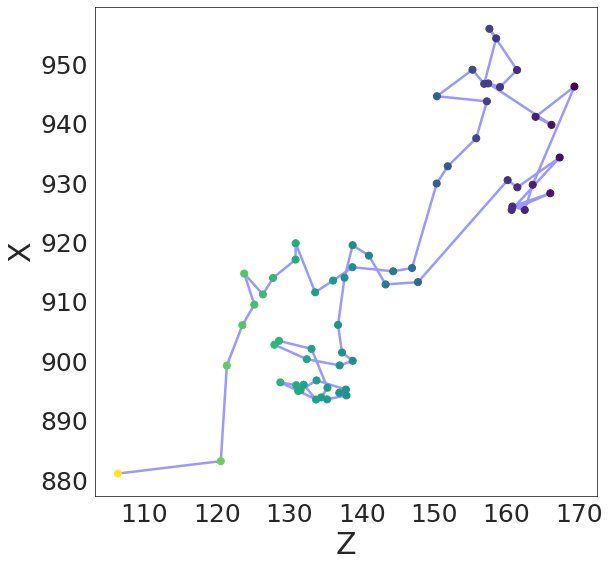

In [72]:
cols=['Position X','Position Y','Position Z','Position X']
labels=['X','Y','Z','X']
for i,df in enumerate([df_invivo_5,df_invivo_14,df_invivo_7,df_invivo_13]):
  for j in range(3):
    sns.set_style('white')
    fig=plt.figure(figsize=(9,9))
    plt.scatter(df[cols[j]],df[cols[j+1]],c=df[cols[2]],cmap='viridis_r',s=50,zorder=2)
    plt.plot(df[cols[j]],df[cols[j+1]],c='blue',linewidth=2.5,zorder=1,alpha=0.4)
    # plt.title('2D({}{}) projection of in vivo sperm {}'.format(labels[j],labels[j+1],i+1),fontsize=20)
    plt.xlabel(labels[j],fontsize=30)
    plt.ylabel(labels[j+1],fontsize=30)
    plt.xticks(size=25)
    plt.yticks(size=25)
    plt.savefig("/content/drive/MyDrive/071422_sperm_mod/082522_OCT_trj_in_vivo_select/2D_trj_in_vivo_select_{}_{}{}.png".format(i+1,labels[j],labels[j+1]),bbox_inches='tight',dpi=100)
    plt.show()